# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

# Solución

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import string

import glob
import re

## Carga de datos

In [4]:
df = pd.DataFrame(columns = ['label', 'content'])

folders = glob.glob("./datos/spam-filter/*")
for folder_aux in folders:
    folder_name = folder_aux + "/*"
    folder = glob.glob(folder_name)
    for file in folder:
        try:
            with open(file, encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            with open(file, 'rb') as f:
                content = f.read()
        df = df.append({'label': 0 if 'ham' in folder_name else 1, 
                        'content': str(content).replace('\\n', '\n')}, ignore_index=True)
        
df.to_csv(r'datos/spam-filter/dataFrame.csv')

def remove_header(cols):
    array_first = cols[1].replace('\\n', '\n').split('\n')
    index_remove = 0
    pattern = r'^[A-Za-z-]*: [a-zA-Z 0-9@.[\]\(\)-]*'
    for index, element in enumerate(array_first):
        if re.search(pattern, element):
            index_remove = index
    return '\n'.join(array_first[index_remove + 1:]).strip()

def remove_tags_HTML(cols):
    content = cols[1]
    TAG_RE = re.compile(r'<[^>]+>')
    TAG_REX = re.compile(r"\s+")
    content = TAG_RE.sub('', content)
    content = TAG_REX.sub(' ', content)
    return content

def remove_spaces_tab(cols):
    content = cols[1]
    return content.replace("\n","").strip("\t")

def remove_web(cols):
    content = cols[1]
    TAG_RE = re.compile(r'https?:\/\/.*[\n]*')
    return TAG_RE.sub('', content)

def remove_numbers(cols):
    content = cols[1]
    TAG_RE = re.compile(r'[0-9]*')
    return TAG_RE.sub('', content)

df['content'] = df.apply(remove_header, axis=1)
df['content'] = df.apply(remove_tags_HTML, axis=1)
df['content'] = df.apply(remove_spaces_tab, axis=1)
df['content'] = df.apply(remove_numbers, axis=1)
df['content'] = df.apply(remove_web, axis=1)

X = df['content']
y = df['label']

## Procesando el lenguaje natural

In [6]:
stemmer = SnowballStemmer("english")
nltk.download('stopwords')

def cleanText(message):    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)
    
X = list(map(cleanText, X))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Diccionario de palabras

In [7]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X.shape

(6299, 60982)

In [8]:
X = X.toarray()

X[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Modelo

Se relaiza una regresión logística

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [10]:
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.3,random_state=101)

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

C:\Users\santi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


array([[1297,   23],
       [  80,  490]], dtype=int64)

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9455026455026455
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1320
           1       0.96      0.86      0.90       570

   micro avg       0.95      0.95      0.95      1890
   macro avg       0.95      0.92      0.93      1890
weighted avg       0.95      0.95      0.94      1890



## Clasificación por medio de redes neuronales

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Dropout

Using TensorFlow backend.


Se busca el número de capas ideal

In [14]:
def grid_layers(capas):
    param = []

    for i in range(len(capas)):
        classifier = Sequential()

        classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 60982))

        for j in range(capas[i]-1):
            classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 50, epochs = 30)

        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)

        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])

    return param

layers = [2,5,8]

resultado = grid_layers(layers)

Epoch 1/30
4409/4409 [==============================] - 36s 8ms/step - loss: 0.6549 - acc: 0.6938
Epoch 2/30
4409/4409 [==============================] - 18s 4ms/step - loss: 0.4483 - acc: 0.7437
Epoch 3/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.2580 - acc: 0.9401
Epoch 4/30
4409/4409 [==============================] - 6s 1ms/step - loss: 0.1501 - acc: 0.9619
Epoch 5/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.1037 - acc: 0.9712
Epoch 6/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0794 - acc: 0.9782
Epoch 7/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.0643 - acc: 0.9823
Epoch 8/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0534 - acc: 0.9848
Epoch 9/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0453 - acc: 0.9864
Epoch 10/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0398 - acc: 0.9878
Epoch 11/30
4409/4409 [====

4409/4409 [==============================] - 7s 2ms/step - loss: 0.0651 - acc: 0.9923
Epoch 13/30
4409/4409 [==============================] - 6s 1ms/step - loss: 0.0579 - acc: 0.9921
Epoch 14/30
4409/4409 [==============================] - 6s 1ms/step - loss: 0.0523 - acc: 0.9918
Epoch 15/30
4409/4409 [==============================] - 7s 1ms/step - loss: 0.0484 - acc: 0.9923
Epoch 16/30
4409/4409 [==============================] - 7s 1ms/step - loss: 0.0443 - acc: 0.9923
Epoch 17/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.0422 - acc: 0.9921
Epoch 18/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.0393 - acc: 0.9921A: 
Epoch 19/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.0384 - acc: 0.9921
Epoch 20/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.0364 - acc: 0.9918
Epoch 21/30
4409/4409 [==============================] - 7s 2ms/step - loss: 0.0355 - acc: 0.9923
Epoch 22/30
4409/4409 [======

In [15]:
resultado

[[None, array([[1293,   27],
         [  61,  509]], dtype=int64), [0.1924540517533878,
   0.9534391534391534]],
 [None, array([[1294,   26],
         [  73,  497]], dtype=int64), [0.27616665547158087,
   0.9476190476190476]],
 [None, array([[1291,   29],
         [  56,  514]], dtype=int64), [0.22601457802626274,
   0.955026455026455]]]

<BarContainer object of 3 artists>

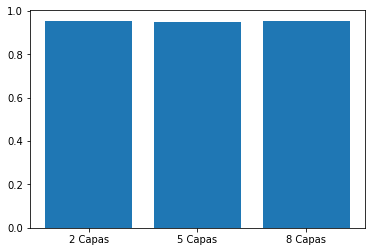

In [17]:
precision = [i[2][1] for i in resultado]

plt.bar(["2 Capas","5 Capas","8 Capas"],precision)

Luego de ver las capas qeu se deben usar se busca el númeor de neuronas

In [18]:
def grid_neurons(neuronas):
    param = []
  
    for i in range(len(neuronas)):
        classifier = Sequential()

        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu', input_dim = 60982))
        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 32, epochs = 30)

        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)

        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])

    return param

neurons = [8,16,32,64]

resultado_neuronas = grid_neurons(neurons)

Epoch 1/30
4409/4409 [==============================] - 54s 12ms/step - loss: 0.5381 - acc: 0.7804
Epoch 2/30
4409/4409 [==============================] - 9s 2ms/step - loss: 0.1922 - acc: 0.9478
Epoch 3/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0987 - acc: 0.9698
Epoch 4/30
4409/4409 [==============================] - 9s 2ms/step - loss: 0.0674 - acc: 0.9814
Epoch 5/30
4409/4409 [==============================] - 12s 3ms/step - loss: 0.0510 - acc: 0.9868
Epoch 6/30
4409/4409 [==============================] - 10s 2ms/step - loss: 0.0413 - acc: 0.9880
Epoch 7/30
4409/4409 [==============================] - 10s 2ms/step - loss: 0.0350 - acc: 0.9896
Epoch 8/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0308 - acc: 0.9907
Epoch 9/30
4409/4409 [==============================] - 10s 2ms/step - loss: 0.0277 - acc: 0.9918
Epoch 10/30
4409/4409 [==============================] - 13s 3ms/step - loss: 0.0256 - acc: 0.9918
Epoch 11/30
4409/4409 

4409/4409 [==============================] - 15s 3ms/step - loss: 0.0228 - acc: 0.9936
Epoch 9/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0221 - acc: 0.9946
Epoch 10/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0220 - acc: 0.9941
Epoch 11/30
4409/4409 [==============================] - 14s 3ms/step - loss: 0.0216 - acc: 0.9941
Epoch 12/30
4409/4409 [==============================] - 14s 3ms/step - loss: 0.0216 - acc: 0.9943
Epoch 13/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0214 - acc: 0.9943
Epoch 14/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0214 - acc: 0.9939
Epoch 15/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0210 - acc: 0.9943
Epoch 16/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0219 - acc: 0.9939
Epoch 17/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0213 - acc: 0.9936
Epoch 18/30
4409/4409 [

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156851). Check your callbacks.
  % delta_t_median)
C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101875). Check your callbacks.
  % delta_t_median)


4409/4409 [==============================] - 17s 4ms/step - loss: 0.0208 - acc: 0.9943
Epoch 24/30
4409/4409 [==============================] - 15s 4ms/step - loss: 0.0212 - acc: 0.9943
Epoch 25/30
4409/4409 [==============================] - 16s 4ms/step - loss: 0.0209 - acc: 0.9941
Epoch 26/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0210 - acc: 0.9941
Epoch 27/30
4409/4409 [==============================] - 17s 4ms/step - loss: 0.0210 - acc: 0.9939
Epoch 28/30
4409/4409 [==============================] - 14s 3ms/step - loss: 0.0202 - acc: 0.9941
Epoch 29/30
4409/4409 [==============================] - 15s 3ms/step - loss: 0.0211 - acc: 0.9941
Epoch 30/30
4409/4409 [==============================] - 14s 3ms/step - loss: 0.0209 - acc: 0.9941
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                1951456   
______________________

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262357). Check your callbacks.
  % delta_t_median)
C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139174). Check your callbacks.
  % delta_t_median)


4409/4409 [==============================] - 223s 51ms/step - loss: 0.0286 - acc: 0.9934
Epoch 14/30
4409/4409 [==============================] - 37s 8ms/step - loss: 0.0285 - acc: 0.9939
Epoch 15/30
4409/4409 [==============================] - 26s 6ms/step - loss: 0.0287 - acc: 0.9936
Epoch 16/30
4409/4409 [==============================] - 22s 5ms/step - loss: 0.0288 - acc: 0.9934
Epoch 17/30
4409/4409 [==============================] - 23s 5ms/step - loss: 0.0285 - acc: 0.9939
Epoch 18/30
4409/4409 [==============================] - 22s 5ms/step - loss: 0.0289 - acc: 0.9936
Epoch 19/30
4409/4409 [==============================] - 22s 5ms/step - loss: 0.0283 - acc: 0.9936
Epoch 20/30
4409/4409 [==============================] - 22s 5ms/step - loss: 0.0286 - acc: 0.9936
Epoch 21/30
4409/4409 [==============================] - 22s 5ms/step - loss: 0.0282 - acc: 0.9932
Epoch 22/30
4409/4409 [==============================] - 22s 5ms/step - loss: 0.0286 - acc: 0.9936
Epoch 23/30
4409/440

In [20]:
resultado_neuronas

[[None, array([[1292,   28],
         [  67,  503]], dtype=int64), [0.24515310031926707,
   0.9497354497354498]],
 [None, array([[1296,   24],
         [  67,  503]], dtype=int64), [0.22850030831116125,
   0.9518518518518518]],
 [None, array([[1287,   33],
         [  55,  515]], dtype=int64), [0.25002530167429343,
   0.9534391534391534]],
 [None, array([[1289,   31],
         [  50,  520]], dtype=int64), [0.2324087665486211,
   0.9571428571428572]]]

In [21]:
def regresor_base(optimizer,activation):
    modelo = Sequential()
    modelo.add(Dense(units = 8, kernel_initializer = 'uniform', activation = activation, input_dim = 60982))
    modelo.add(Dropout(p = 0.1))
    modelo.add(Dense(units = 8, kernel_initializer = 'uniform', activation = activation))
    modelo.add(Dropout(p = 0.1))
    modelo.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    modelo.compile(optimizer = optimizer, loss = 'binary_crossentropy' ,metrics = ['accuracy'])
    
    return  modelo


regresor = KerasClassifier(build_fn = regresor_base)

parameters = {'batch_size': [5,10,20,50],
              'epochs': [20,40,60,100],
              'optimizer': ['adam'],
              'activation':['sigmoid','relu']              
             }

## Cross validation 
grid_search = GridSearchCV(estimator = regresor,
                           param_grid = parameters,
                           cv=2
                           )
grid_search = grid_search.fit(X_train, y_train)

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2204/2204 [==============================] - 23s 11ms/step - loss: 0.6113 - acc: 0.6897
Epoch 2/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.5309 - acc: 0.6897: 0s - loss: 0.5298 - acc: 
Epoch 3/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.4681 - acc: 0.6897
Epoch 4/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.3979 - acc: 0.6897
Epoch 5/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.3276 - acc: 0.7650: 1s - los
Epoch 6/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.2672 - acc: 0.9483
Epoch 7/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.2169 - acc: 0.9728
Epoch 8/20
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1782 - acc: 0.9814
Epoch 9/20
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1465 - acc: 0.9855
Epoch 10/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2205/2205 [==============================] - 27s 12ms/step - loss: 0.6008 - acc: 0.6971
Epoch 2/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.5151 - acc: 0.7075
Epoch 3/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.4525 - acc: 0.7075:
Epoch 4/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.3845 - acc: 0.7075
Epoch 5/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.3195 - acc: 0.7433
Epoch 6/20
2205/2205 [==============================] - 11s 5ms/step - loss: 0.2599 - acc: 0.9365
Epoch 7/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.2130 - acc: 0.9751
Epoch 8/20
2205/2205 [==============================] - 10s 4ms/step - loss: 0.1717 - acc: 0.9846
Epoch 9/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.1406 - acc: 0.9887
Epoch 10/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.1164 - acc: 0.9905
Epoch 11/20
2205/

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2204/2204 [==============================] - 47s 21ms/step - loss: 0.6081 - acc: 0.6892
Epoch 2/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.5327 - acc: 0.6897
Epoch 3/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.4702 - acc: 0.6897
Epoch 4/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.4008 - acc: 0.6901
Epoch 5/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.3348 - acc: 0.7418
Epoch 6/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.2737 - acc: 0.9451
Epoch 7/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.2213 - acc: 0.9723
Epoch 8/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.1804 - acc: 0.9837
Epoch 9/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1489 - acc: 0.9864
Epoch 10/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1250 - acc: 0.9868
Epoch 11/40
2204/2

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2205/2205 [==============================] - 25s 11ms/step - loss: 0.5942 - acc: 0.7070
Epoch 2/40
2205/2205 [==============================] - 10s 4ms/step - loss: 0.5142 - acc: 0.7075
Epoch 3/40
2205/2205 [==============================] - 10s 5ms/step - loss: 0.4526 - acc: 0.7075
Epoch 4/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.3855 - acc: 0.7075
Epoch 5/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.3196 - acc: 0.7429
Epoch 6/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.2612 - acc: 0.9333
Epoch 7/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.2129 - acc: 0.9741
Epoch 8/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1737 - acc: 0.9823
Epoch 9/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1408 - acc: 0.9891A: 0s - loss: 0.1407
Epoch 10/40
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1215 - acc: 0.9887
Epoch

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2204/2204 [==============================] - 34s 15ms/step - loss: 0.6037 - acc: 0.6897
Epoch 2/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.5293 - acc: 0.6897
Epoch 3/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.4656 - acc: 0.6897
Epoch 4/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.3998 - acc: 0.6906
Epoch 5/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.3297 - acc: 0.7550
Epoch 6/60
2204/2204 [==============================] - 10s 4ms/step - loss: 0.2684 - acc: 0.9487
Epoch 7/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.2193 - acc: 0.9696
Epoch 8/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1790 - acc: 0.9814: 1
Epoch 9/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1467 - acc: 0.9841
Epoch 10/60
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1233 - acc: 0.9859
Epoch 11/60
220

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
  15/2205 [..............................] - ETA: 58:33 - loss: 0.6956 - acc: 0.4000  

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125505). Check your callbacks.
  % delta_t_median)


2205/2205 [==============================] - 42s 19ms/step - loss: 0.6008 - acc: 0.7034
Epoch 2/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.5165 - acc: 0.7075
Epoch 3/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.4531 - acc: 0.7075
Epoch 4/60
2205/2205 [==============================] - 10s 4ms/step - loss: 0.3866 - acc: 0.7075
Epoch 5/60
2205/2205 [==============================] - 10s 5ms/step - loss: 0.3187 - acc: 0.7401
Epoch 6/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.2602 - acc: 0.9415
Epoch 7/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.2144 - acc: 0.9705
Epoch 8/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1729 - acc: 0.9810
Epoch 9/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1437 - acc: 0.9878
Epoch 10/60
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1178 - acc: 0.9900
Epoch 11/60
2205/2205 [=============

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2204/2204 [==============================] - 27s 12ms/step - loss: 0.6181 - acc: 0.6729
Epoch 2/100
2204/2204 [==============================] - 10s 4ms/step - loss: 0.5328 - acc: 0.6897
Epoch 3/100
2204/2204 [==============================] - 10s 4ms/step - loss: 0.4670 - acc: 0.6897
Epoch 4/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.3979 - acc: 0.6901
Epoch 5/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.3280 - acc: 0.7591
Epoch 6/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.2691 - acc: 0.9483
Epoch 7/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.2174 - acc: 0.9714
Epoch 8/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.1781 - acc: 0.9823
Epoch 9/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.1458 - acc: 0.9859
Epoch 10/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.1247 - acc: 0.9864
Epoch 11/1

2204/2204 [==============================] - 9s 4ms/step - loss: 0.0211 - acc: 0.9923
Epoch 82/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0242 - acc: 0.9905
Epoch 83/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0236 - acc: 0.9896A: 0s - loss: 0.0238 - a
Epoch 84/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0266 - acc: 0.9896
Epoch 85/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0254 - acc: 0.9909
Epoch 86/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0285 - acc: 0.9887
Epoch 87/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0231 - acc: 0.9909
Epoch 88/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0227 - acc: 0.9914
Epoch 89/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0244 - acc: 0.9909
Epoch 90/100
2204/2204 [==============================] - 9s 4ms/step - loss: 0.0253 - acc: 0.9905

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
  30/2205 [..............................] - ETA: 10:51 - loss: 0.6940 - acc: 0.4333

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141664). Check your callbacks.
  % delta_t_median)


2205/2205 [==============================] - 25s 11ms/step - loss: 0.5995 - acc: 0.7025
Epoch 2/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.5130 - acc: 0.7075
Epoch 3/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.4478 - acc: 0.7075
Epoch 4/100
2205/2205 [==============================] - 10s 5ms/step - loss: 0.3812 - acc: 0.7075
Epoch 5/100
2205/2205 [==============================] - 10s 5ms/step - loss: 0.3130 - acc: 0.7601
Epoch 6/100
2205/2205 [==============================] - 10s 5ms/step - loss: 0.2565 - acc: 0.9537
Epoch 7/100
2205/2205 [==============================] - 10s 5ms/step - loss: 0.2074 - acc: 0.9760
Epoch 8/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.1698 - acc: 0.9837
Epoch 9/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.1397 - acc: 0.9864
Epoch 10/100
2205/2205 [==============================] - 10s 5ms/step - loss: 0.1159 - acc: 0.9887
Epoch 11/100
2205/22

2205/2205 [==============================] - 9s 4ms/step - loss: 0.0200 - acc: 0.9932
Epoch 81/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.0193 - acc: 0.9923
Epoch 82/100
2205/2205 [==============================] - 9s 4ms/step - loss: 0.0261 - acc: 0.9909
Epoch 83/100
2205/2205 [==============================] - 9s 4ms/step - loss: 0.0236 - acc: 0.9905
Epoch 84/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.0153 - acc: 0.9950
Epoch 85/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.0232 - acc: 0.9932: 0s - loss: 0.0225 - acc: 0.
Epoch 86/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.0229 - acc: 0.9909
Epoch 87/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.0181 - acc: 0.9927: 1s -
Epoch 88/100
2205/2205 [==============================] - 10s 4ms/step - loss: 0.0231 - acc: 0.9932
Epoch 89/100
2205/2205 [==============================] - 9s 4ms/step - loss: 0.0

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2204/2204 [==============================] - 48s 22ms/step - loss: 0.6363 - acc: 0.6851
Epoch 2/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5591 - acc: 0.6897
Epoch 3/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5184 - acc: 0.6897
Epoch 4/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4780 - acc: 0.6897
Epoch 5/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4335 - acc: 0.6897
Epoch 6/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3861 - acc: 0.6897
Epoch 7/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3433 - acc: 0.7028
Epoch 8/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3023 - acc: 0.8299
Epoch 9/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2667 - acc: 0.9551
Epoch 10/20
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2345 - acc: 0.9673A: 0s - loss: 0.2367 - acc: 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
  20/2205 [..............................] - ETA: 33:52 - loss: 0.6781 - acc: 0.7000  

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174036). Check your callbacks.
  % delta_t_median)


2205/2205 [==============================] - 39s 18ms/step - loss: 0.6113 - acc: 0.7075
Epoch 2/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.5416 - acc: 0.7075
Epoch 3/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.5033 - acc: 0.7075
Epoch 4/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.4624 - acc: 0.7075A: 4s - loss: 0.4898 - acc: 0.698 
Epoch 5/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.4208 - acc: 0.7075
Epoch 6/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.3761 - acc: 0.7075A: 5s - loss: 0 - ETA: 4s - loss: - ETA: 3s - loss: 0.3793 - a - ETA: 2s - loss: - ETA: 1s - l
Epoch 7/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.3350 - acc: 0.7134
Epoch 8/20
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2959 - acc: 0.7950A: 0s - loss: 0.3016 -
Epoch 9/20
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2601 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2204/2204 [==============================] - 19s 8ms/step - loss: 0.6427 - acc: 0.6638
Epoch 2/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5625 - acc: 0.6897
Epoch 3/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5199 - acc: 0.6897
Epoch 4/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4790 - acc: 0.6897
Epoch 5/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4331 - acc: 0.6897
Epoch 6/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3892 - acc: 0.6906
Epoch 7/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3447 - acc: 0.7024
Epoch 8/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3027 - acc: 0.8362
Epoch 9/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2670 - acc: 0.9555
Epoch 10/40
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2318 - acc: 0.9728
Epoch 11/40
2204/2204 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2205/2205 [==============================] - 19s 8ms/step - loss: 0.6137 - acc: 0.7075
Epoch 2/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.5433 - acc: 0.7075
Epoch 3/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.5027 - acc: 0.7075
Epoch 4/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.4636 - acc: 0.7075
Epoch 5/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.4205 - acc: 0.7075
Epoch 6/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.3760 - acc: 0.7079
Epoch 7/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.3345 - acc: 0.7134A: 0s - loss: 0.3377 - acc:
Epoch 8/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2930 - acc: 0.7946
Epoch 9/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2586 - acc: 0.9569
Epoch 10/40
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2267 - acc: 0.9714
E

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2204/2204 [==============================] - 17s 8ms/step - loss: 0.6343 - acc: 0.6856
Epoch 2/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5508 - acc: 0.6897
Epoch 3/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4829 - acc: 0.6897
Epoch 4/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4180 - acc: 0.6897
Epoch 5/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3558 - acc: 0.6978
Epoch 6/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3022 - acc: 0.8811
Epoch 7/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2582 - acc: 0.9369
Epoch 8/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2219 - acc: 0.9483
Epoch 9/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.1966 - acc: 0.9574
Epoch 10/60
2204/2204 [==============================] - 6s 3ms/step - loss: 0.1725 - acc: 0.9696
Epoch 11/60
2204/2204 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2205/2205 [==============================] - 16s 7ms/step - loss: 0.6101 - acc: 0.7075
Epoch 2/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.5409 - acc: 0.7075A: 0s - loss: 0.5453 - 
Epoch 3/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.5015 - acc: 0.7075
Epoch 4/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.4625 - acc: 0.7075
Epoch 5/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.4179 - acc: 0.7075
Epoch 6/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.3781 - acc: 0.7075A: 
Epoch 7/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.3347 - acc: 0.7147
Epoch 8/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2954 - acc: 0.7891
Epoch 9/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2591 - acc: 0.9515
Epoch 10/60
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2306 - acc: 0.9728
Ep

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2204/2204 [==============================] - 27s 12ms/step - loss: 0.6344 - acc: 0.6887
Epoch 2/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5611 - acc: 0.6897
Epoch 3/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.5196 - acc: 0.6897
Epoch 4/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4787 - acc: 0.6897
Epoch 5/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.4345 - acc: 0.6897
Epoch 6/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3886 - acc: 0.6906
Epoch 7/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3448 - acc: 0.7069
Epoch 8/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.3032 - acc: 0.8280
Epoch 9/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2663 - acc: 0.9528
Epoch 10/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.2327 - acc: 0.9687
Epoch 11/100
2204

2204/2204 [==============================] - 6s 3ms/step - loss: 0.0226 - acc: 0.9918
Epoch 83/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0230 - acc: 0.9909
Epoch 84/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0264 - acc: 0.9896
Epoch 85/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0231 - acc: 0.9927
Epoch 86/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0280 - acc: 0.9900
Epoch 87/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0234 - acc: 0.9923
Epoch 88/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0226 - acc: 0.9914
Epoch 89/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0224 - acc: 0.9900
Epoch 90/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0243 - acc: 0.9900
Epoch 91/100
2204/2204 [==============================] - 6s 3ms/step - loss: 0.0240 - acc: 0.9891
Epoch 92/100
2204/2204 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2205/2205 [==============================] - 37s 17ms/step - loss: 0.6287 - acc: 0.6980
Epoch 2/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.5458 - acc: 0.7075
Epoch 3/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.5044 - acc: 0.7075
Epoch 4/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.4631 - acc: 0.7075A:
Epoch 5/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.4198 - acc: 0.7075
Epoch 6/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.3783 - acc: 0.7075
Epoch 7/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.3362 - acc: 0.7129
Epoch 8/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2961 - acc: 0.7778
Epoch 9/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2598 - acc: 0.9383
Epoch 10/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.2282 - acc: 0.9741
Epoch 11/100
22

2205/2205 [==============================] - 6s 3ms/step - loss: 0.0168 - acc: 0.9941
Epoch 82/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0192 - acc: 0.9937
Epoch 83/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0175 - acc: 0.9932
Epoch 84/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0206 - acc: 0.9927
Epoch 85/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0222 - acc: 0.9927
Epoch 86/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0155 - acc: 0.9950
Epoch 87/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0233 - acc: 0.9923
Epoch 88/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0127 - acc: 0.9977
Epoch 89/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0154 - acc: 0.9950
Epoch 90/100
2205/2205 [==============================] - 6s 3ms/step - loss: 0.0236 - acc: 0.9918
Epoch 91/100
2205/2205 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2204/2204 [==============================] - 19s 8ms/step - loss: 0.6536 - acc: 0.6897
Epoch 2/20
 100/2204 [>.............................] - ETA: 15s - loss: 0.6508 - acc: 0.6200

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187262). Check your callbacks.
  % delta_t_median)


2204/2204 [==============================] - 5s 2ms/step - loss: 0.5901 - acc: 0.6897A: 2s - los
Epoch 3/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5563 - acc: 0.6897
Epoch 4/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5295 - acc: 0.6897
Epoch 5/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5036 - acc: 0.6897
Epoch 6/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4798 - acc: 0.6897
Epoch 7/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4525 - acc: 0.6897
Epoch 8/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4275 - acc: 0.6897
Epoch 9/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4014 - acc: 0.6897
Epoch 10/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.3730 - acc: 0.6901
Epoch 11/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.3482 - acc: 0.6965
Epoch 12/20
2204/2204 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2205/2205 [==============================] - 21s 9ms/step - loss: 0.6529 - acc: 0.6812
Epoch 2/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5763 - acc: 0.7075
Epoch 3/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5405 - acc: 0.7075
Epoch 4/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5109 - acc: 0.7075
Epoch 5/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4895 - acc: 0.7075
Epoch 6/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4650 - acc: 0.7075
Epoch 7/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4404 - acc: 0.7075
Epoch 8/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4145 - acc: 0.7075
Epoch 9/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3861 - acc: 0.7075
Epoch 10/20
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3616 - acc: 0.7075
Epoch 11/20
2205/2205 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2204/2204 [==============================] - 20s 9ms/step - loss: 0.6665 - acc: 0.6338
Epoch 2/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5991 - acc: 0.6897
Epoch 3/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5584 - acc: 0.6897
Epoch 4/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5327 - acc: 0.6897
Epoch 5/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5089 - acc: 0.6897
Epoch 6/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4848 - acc: 0.6897
Epoch 7/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4565 - acc: 0.6897
Epoch 8/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4313 - acc: 0.6897
Epoch 9/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4058 - acc: 0.6897
Epoch 10/40
2204/2204 [==============================] - 4s 2ms/step - loss: 0.3770 - acc: 0.6910
Epoch 11/40
2204/2204 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2205/2205 [==============================] - 34s 15ms/step - loss: 0.6584 - acc: 0.6653
Epoch 2/40
2205/2205 [==============================] - 5s 2ms/step - loss: 0.5837 - acc: 0.7075
Epoch 3/40
2205/2205 [==============================] - 5s 2ms/step - loss: 0.5386 - acc: 0.7075
Epoch 4/40
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5151 - acc: 0.7075
Epoch 5/40
2205/2205 [==============================] - 5s 2ms/step - loss: 0.4909 - acc: 0.7075
Epoch 6/40
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4640 - acc: 0.7075
Epoch 7/40
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4389 - acc: 0.7075
Epoch 8/40
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4115 - acc: 0.7075
Epoch 9/40
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3872 - acc: 0.7075
Epoch 10/40
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3611 - acc: 0.7075
Epoch 11/40
2205/2205 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2204/2204 [==============================] - 21s 10ms/step - loss: 0.6566 - acc: 0.6688
Epoch 2/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5930 - acc: 0.6897
Epoch 3/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5562 - acc: 0.6897
Epoch 4/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5302 - acc: 0.6897
Epoch 5/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5077 - acc: 0.6897
Epoch 6/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4787 - acc: 0.6897
Epoch 7/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4531 - acc: 0.6897
Epoch 8/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4279 - acc: 0.6897
Epoch 9/60
2204/2204 [==============================] - 4s 2ms/step - loss: 0.3999 - acc: 0.6901
Epoch 10/60
2204/2204 [==============================] - 5s 2ms/step - loss: 0.3749 - acc: 0.6910
Epoch 11/60
2204/2204 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2205/2205 [==============================] - 19s 9ms/step - loss: 0.6643 - acc: 0.6490
Epoch 2/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5889 - acc: 0.7075
Epoch 3/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5439 - acc: 0.7075
Epoch 4/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5176 - acc: 0.7075
Epoch 5/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4927 - acc: 0.7075
Epoch 6/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4708 - acc: 0.7075
Epoch 7/60
2205/2205 [==============================] - ETA: 0s - loss: 0.4461 - acc: 0.706 - 4s 2ms/step - loss: 0.4455 - acc: 0.7075
Epoch 8/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4192 - acc: 0.7075
Epoch 9/60
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3938 - acc: 0.7075A: 1s - loss: 0
Epoch 10/60
2205/2205 [==============================] - 4s 2ms/step - lo

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2204/2204 [==============================] - 31s 14ms/step - loss: 0.6538 - acc: 0.6878
Epoch 2/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5915 - acc: 0.6897
Epoch 3/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5550 - acc: 0.6897
Epoch 4/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5314 - acc: 0.6897
Epoch 5/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.5055 - acc: 0.6897
Epoch 6/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4794 - acc: 0.6897
Epoch 7/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.4528 - acc: 0.6897A: 1s - loss:
Epoch 8/100
2204/2204 [==============================] - 5s 2ms/step - loss: 0.4235 - acc: 0.6897
Epoch 9/100
2204/2204 [==============================] - 5s 2ms/step - loss: 0.3966 - acc: 0.6897
Epoch 10/100
2204/2204 [==============================] - 5s 2ms/step - loss: 0.3702 - acc: 0.6906
Epoc

2204/2204 [==============================] - 5s 2ms/step - loss: 0.0243 - acc: 0.9927
Epoch 84/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0257 - acc: 0.9909
Epoch 85/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0273 - acc: 0.9927
Epoch 86/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0274 - acc: 0.9914
Epoch 87/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0261 - acc: 0.9914
Epoch 88/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0259 - acc: 0.9927
Epoch 89/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0238 - acc: 0.9918
Epoch 90/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0262 - acc: 0.9923
Epoch 91/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0272 - acc: 0.9932
Epoch 92/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0249 - acc: 0.9914
Epoch 93/100
2204/2204 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2205/2205 [==============================] - 17s 8ms/step - loss: 0.6653 - acc: 0.6385
Epoch 2/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5924 - acc: 0.7075
Epoch 3/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.5369 - acc: 0.7075
Epoch 4/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4934 - acc: 0.7075
Epoch 5/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4523 - acc: 0.7075
Epoch 6/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.4113 - acc: 0.7075
Epoch 7/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3736 - acc: 0.7075
Epoch 8/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3420 - acc: 0.7079
Epoch 9/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.3079 - acc: 0.7215
Epoch 10/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.2832 - acc: 0.8621
Epoch 11/100
2205/

2205/2205 [==============================] - 4s 2ms/step - loss: 0.0273 - acc: 0.9932
Epoch 84/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0256 - acc: 0.9937
Epoch 85/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0258 - acc: 0.9927
Epoch 86/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0233 - acc: 0.9937
Epoch 87/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0240 - acc: 0.9927A: 0s - loss: 0.0224 - acc: 0.9
Epoch 88/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0207 - acc: 0.9946
Epoch 89/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0249 - acc: 0.9914
Epoch 90/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0291 - acc: 0.9918
Epoch 91/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0227 - acc: 0.9937
Epoch 92/100
2205/2205 [==============================] - 4s 2ms/step - loss: 0.0210 - acc:

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2204/2204 [==============================] - 19s 9ms/step - loss: 0.6767 - acc: 0.6647
Epoch 2/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.6407 - acc: 0.6897
Epoch 3/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.6082 - acc: 0.6897
Epoch 4/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5817 - acc: 0.6897
Epoch 5/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5639 - acc: 0.6897
Epoch 6/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5512 - acc: 0.6897
Epoch 7/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5372 - acc: 0.6897
Epoch 8/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5243 - acc: 0.6897
Epoch 9/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5130 - acc: 0.6897
Epoch 10/20
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5022 - acc: 0.6897
Epoch 11/20
2204/2204 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2205/2205 [==============================] - 23s 10ms/step - loss: 0.6690 - acc: 0.7061
Epoch 2/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.6306 - acc: 0.7075
Epoch 3/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5938 - acc: 0.7075
Epoch 4/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5684 - acc: 0.7075
Epoch 5/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5478 - acc: 0.7075
Epoch 6/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5315 - acc: 0.7075
Epoch 7/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5211 - acc: 0.7075
Epoch 8/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5068 - acc: 0.7075
Epoch 9/20
2205/2205 [==============================] - 3s 1ms/step - loss: 0.4966 - acc: 0.7075
Epoch 10/20
2205/2205 [==============================] - 3s 2ms/step - loss: 0.4844 - acc: 0.7075
Epoch 11/20
2205/2205 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2204/2204 [==============================] - 28s 13ms/step - loss: 0.6668 - acc: 0.6901
Epoch 2/40
2204/2204 [==============================] - 3s 2ms/step - loss: 0.6344 - acc: 0.6897
Epoch 3/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.6037 - acc: 0.6897
Epoch 4/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5806 - acc: 0.6897
Epoch 5/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5628 - acc: 0.6897
Epoch 6/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5483 - acc: 0.6897
Epoch 7/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5346 - acc: 0.6897
Epoch 8/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5222 - acc: 0.6897
Epoch 9/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5100 - acc: 0.6897
Epoch 10/40
2204/2204 [==============================] - 3s 1ms/step - loss: 0.4951 - acc: 0.6897
Epoch 11/40
2204/2204 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2205/2205 [==============================] - 29s 13ms/step - loss: 0.6772 - acc: 0.6508
Epoch 2/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.6395 - acc: 0.7075
Epoch 3/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.6041 - acc: 0.7075
Epoch 4/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5733 - acc: 0.7075
Epoch 5/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5531 - acc: 0.7075
Epoch 6/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5381 - acc: 0.7075
Epoch 7/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5246 - acc: 0.7075
Epoch 8/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5110 - acc: 0.7075
Epoch 9/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5018 - acc: 0.7075
Epoch 10/40
2205/2205 [==============================] - 3s 1ms/step - loss: 0.4875 - acc: 0.7075
Epoch 11/40
2205/2205 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2204/2204 [==============================] - 19s 9ms/step - loss: 0.6772 - acc: 0.6638
Epoch 2/60
2204/2204 [==============================] - 3s 2ms/step - loss: 0.6426 - acc: 0.6897
Epoch 3/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.6084 - acc: 0.6897
Epoch 4/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5835 - acc: 0.6897
Epoch 5/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5658 - acc: 0.6897
Epoch 6/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5511 - acc: 0.6897
Epoch 7/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5385 - acc: 0.6897
Epoch 8/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5258 - acc: 0.6897
Epoch 9/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5117 - acc: 0.6897
Epoch 10/60
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5034 - acc: 0.6897
Epoch 11/60
2204/2204 [=====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2205/2205 [==============================] - 27s 12ms/step - loss: 0.6752 - acc: 0.6721
Epoch 2/60
2205/2205 [==============================] - 3s 2ms/step - loss: 0.6358 - acc: 0.7075
Epoch 3/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5982 - acc: 0.7075
Epoch 4/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5695 - acc: 0.7075
Epoch 5/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5505 - acc: 0.7075
Epoch 6/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5334 - acc: 0.7075
Epoch 7/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5197 - acc: 0.7075
Epoch 8/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5066 - acc: 0.7075
Epoch 9/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.4958 - acc: 0.7075
Epoch 10/60
2205/2205 [==============================] - 3s 1ms/step - loss: 0.4848 - acc: 0.7075
Epoch 11/60
2205/2205 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2204/2204 [==============================] - 16s 7ms/step - loss: 0.6833 - acc: 0.6012
Epoch 2/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.6493 - acc: 0.6897
Epoch 3/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.6149 - acc: 0.6897
Epoch 4/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5872 - acc: 0.6897
Epoch 5/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5700 - acc: 0.6897
Epoch 6/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5532 - acc: 0.6897
Epoch 7/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5414 - acc: 0.6897
Epoch 8/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5276 - acc: 0.6897
Epoch 9/100
2204/2204 [==============================] - 3s 2ms/step - loss: 0.5168 - acc: 0.6897
Epoch 10/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.5044 - acc: 0.6897
Epoch 11/100
2204/

2204/2204 [==============================] - 3s 1ms/step - loss: 0.0643 - acc: 0.9941
Epoch 84/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0653 - acc: 0.9918
Epoch 85/100
2204/2204 [==============================] - 3s 2ms/step - loss: 0.0643 - acc: 0.9932
Epoch 86/100
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0635 - acc: 0.9918
Epoch 87/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0591 - acc: 0.9923
Epoch 88/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0608 - acc: 0.9918
Epoch 89/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0588 - acc: 0.9923
Epoch 90/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0576 - acc: 0.9918
Epoch 91/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0578 - acc: 0.9914
Epoch 92/100
2204/2204 [==============================] - 3s 1ms/step - loss: 0.0544 - acc: 0.9932
Epoch 93/100
2204/2204 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2205/2205 [==============================] - 25s 11ms/step - loss: 0.6819 - acc: 0.6145
Epoch 2/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.6432 - acc: 0.7075
Epoch 3/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.6046 - acc: 0.7075
Epoch 4/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5731 - acc: 0.7075
Epoch 5/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5518 - acc: 0.7075
Epoch 6/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5357 - acc: 0.7075
Epoch 7/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5209 - acc: 0.7075
Epoch 8/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.5085 - acc: 0.7075
Epoch 9/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.4964 - acc: 0.7075
Epoch 10/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.4841 - acc: 0.7075
Epoch 11/100
2205

2205/2205 [==============================] - 3s 2ms/step - loss: 0.0594 - acc: 0.9941
Epoch 84/100
2205/2205 [==============================] - 3s 2ms/step - loss: 0.0590 - acc: 0.9950
Epoch 85/100
2205/2205 [==============================] - 3s 2ms/step - loss: 0.0576 - acc: 0.9955
Epoch 86/100
2205/2205 [==============================] - 3s 2ms/step - loss: 0.0533 - acc: 0.9959
Epoch 87/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.0560 - acc: 0.9946
Epoch 88/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.0535 - acc: 0.9950
Epoch 89/100
2205/2205 [==============================] - 3s 2ms/step - loss: 0.0548 - acc: 0.9941
Epoch 90/100
2205/2205 [==============================] - 3s 2ms/step - loss: 0.0526 - acc: 0.9946
Epoch 91/100
2205/2205 [==============================] - 3s 1ms/step - loss: 0.0530 - acc: 0.9937
Epoch 92/100
2205/2205 [==============================] - 3s 2ms/step - loss: 0.0499 - acc: 0.9946
Epoch 93/100
2205/2205 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
  20/2204 [..............................] - ETA: 1:00:46 - loss: 0.6922 - acc: 0.8000

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101555). Check your callbacks.
  % delta_t_median)


2204/2204 [==============================] - 51s 23ms/step - loss: 0.4441 - acc: 0.8158
Epoch 2/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.1489 - acc: 0.9551
Epoch 3/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0932 - acc: 0.9710
Epoch 4/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0791 - acc: 0.9787
Epoch 5/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0475 - acc: 0.9841
Epoch 6/20
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0436 - acc: 0.9887
Epoch 7/20
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0384 - acc: 0.9868A: 2s - loss: 0.0383 - a
Epoch 8/20
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0320 - acc: 0.9896
Epoch 9/20
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0287 - acc: 0.9927
Epoch 10/20
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0260 - acc: 0.9918
Epoch

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2205/2205 [==============================] - 33s 15ms/step - loss: 0.4206 - acc: 0.8313
Epoch 2/20
2205/2205 [==============================] - 11s 5ms/step - loss: 0.1348 - acc: 0.9587
Epoch 3/20
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0866 - acc: 0.9778
Epoch 4/20
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0669 - acc: 0.9859: 1s - l
Epoch 5/20
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0520 - acc: 0.9900
Epoch 6/20
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0488 - acc: 0.9891
Epoch 7/20
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0403 - acc: 0.9909
Epoch 8/20
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0367 - acc: 0.9918: 0s - loss: 0.03
Epoch 9/20
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0347 - acc: 0.9914
Epoch 10/20
2205/2205 [==============================] - 10s 5ms/step - loss: 0.0385 - acc: 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
  10/2204 [..............................] - ETA: 5:09:08 - loss: 0.6927 - acc: 0.6000 

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181210). Check your callbacks.
  % delta_t_median)


2204/2204 [==============================] - 109s 49ms/step - loss: 0.4742 - acc: 0.71371s - loss: 0.4760 - acc: 0.
Epoch 2/40
2204/2204 [==============================] - 12s 5ms/step - loss: 0.2486 - acc: 0.9478
Epoch 3/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.1078 - acc: 0.9814: 1s - lo
Epoch 4/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0640 - acc: 0.9846
Epoch 5/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0442 - acc: 0.9905
Epoch 6/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0398 - acc: 0.9905: 1
Epoch 7/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0371 - acc: 0.9914
Epoch 8/40
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0368 - acc: 0.9909
Epoch 9/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0333 - acc: 0.9914
Epoch 10/40
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0346 - a

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2205/2205 [==============================] - 67s 31ms/step - loss: 0.4939 - acc: 0.7397
Epoch 2/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.1977 - acc: 0.9478
Epoch 3/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.1056 - acc: 0.9800
Epoch 4/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0783 - acc: 0.9864
Epoch 5/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0619 - acc: 0.9891
Epoch 6/40
2205/2205 [==============================] - 10s 5ms/step - loss: 0.0506 - acc: 0.9909
Epoch 7/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0447 - acc: 0.9914
Epoch 8/40
2205/2205 [==============================] - 10s 5ms/step - loss: 0.0434 - acc: 0.9909: 0s - loss: 0.0436 - acc: 0.990
Epoch 9/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0368 - acc: 0.9927
Epoch 10/40
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0356 

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2204/2204 [==============================] - 36s 16ms/step - loss: 0.4720 - acc: 0.8072
Epoch 2/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.1529 - acc: 0.9574
Epoch 3/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0824 - acc: 0.9791
Epoch 4/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0531 - acc: 0.9850
Epoch 5/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0470 - acc: 0.9859: 1s - los
Epoch 6/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0456 - acc: 0.9877
Epoch 7/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0368 - acc: 0.9905
Epoch 8/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0318 - acc: 0.9914
Epoch 9/60
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0312 - acc: 0.9927
Epoch 10/60
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0327 - acc: 0.9896TA - ETA:

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2205/2205 [==============================] - 59s 27ms/step - loss: 0.4442 - acc: 0.7914
Epoch 2/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.1673 - acc: 0.9420
Epoch 3/60
2205/2205 [==============================] - 12s 5ms/step - loss: 0.1162 - acc: 0.9728
Epoch 4/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0837 - acc: 0.9823
Epoch 5/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0764 - acc: 0.9855
Epoch 6/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0576 - acc: 0.9900
Epoch 7/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0513 - acc: 0.9918TA: 0s - loss: 0.054
Epoch 8/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0483 - acc: 0.9909
Epoch 9/60
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0418 - acc: 0.9923: 1s - loss: 
Epoch 10/60
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0381

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
  35/2204 [..............................] - ETA: 28:54 - loss: 0.6931 - acc: 0.4286

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.382850). Check your callbacks.
  % delta_t_median)


2204/2204 [==============================] - 45s 21ms/step - loss: 0.4872 - acc: 0.7831
Epoch 2/100
2204/2204 [==============================] - 12s 6ms/step - loss: 0.1868 - acc: 0.9378
Epoch 3/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.1011 - acc: 0.9760
Epoch 4/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0685 - acc: 0.9819
Epoch 5/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0491 - acc: 0.9846
Epoch 6/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0386 - acc: 0.9882
Epoch 7/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0322 - acc: 0.9887
Epoch 8/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0388 - acc: 0.9914
Epoch 9/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0286 - acc: 0.9914
Epoch 10/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0269 - acc: 0.9923
Epoch 11/100
2204/22

2204/2204 [==============================] - 11s 5ms/step - loss: 0.0206 - acc: 0.9927: 0s - loss: 0.0207 - acc: 
Epoch 82/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0178 - acc: 0.9932
Epoch 83/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0230 - acc: 0.9914
Epoch 84/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0172 - acc: 0.9936
Epoch 85/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0170 - acc: 0.9941
Epoch 86/100
2204/2204 [==============================] - 10s 5ms/step - loss: 0.0172 - acc: 0.9932: 0s - loss: 0.0167 
Epoch 87/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0202 - acc: 0.9918
Epoch 88/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0167 - acc: 0.9932
Epoch 89/100
2204/2204 [==============================] - 11s 5ms/step - loss: 0.0170 - acc: 0.9932: 1s - loss
Epoch 90/100
2204/2204 [==============================]

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2205/2205 [==============================] - 51s 23ms/step - loss: 0.4377 - acc: 0.8345
Epoch 2/100
2205/2205 [==============================] - 12s 5ms/step - loss: 0.1508 - acc: 0.9551
Epoch 3/100
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0829 - acc: 0.9741
Epoch 4/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0772 - acc: 0.9828
Epoch 5/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0523 - acc: 0.9878
Epoch 6/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0434 - acc: 0.9905
Epoch 7/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0370 - acc: 0.9923: 0s - loss: 0.0370 - acc: 0.992
Epoch 8/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0326 - acc: 0.9927
Epoch 9/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0298 - acc: 0.9937: 1s -
Epoch 10/100
2205/2205 [==============================] - 11s 5ms/step

2205/2205 [==============================] - 10s 5ms/step - loss: 0.0188 - acc: 0.9946
Epoch 80/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0178 - acc: 0.9950
Epoch 81/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0186 - acc: 0.9955
Epoch 82/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0188 - acc: 0.9950
Epoch 83/100
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0190 - acc: 0.9955
Epoch 84/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0174 - acc: 0.9955
Epoch 85/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0178 - acc: 0.9955
Epoch 86/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0190 - acc: 0.9950
Epoch 87/100
2205/2205 [==============================] - 11s 5ms/step - loss: 0.0190 - acc: 0.9955: 0s - loss: 0.0200 -
Epoch 88/100
2205/2205 [==============================] - 12s 5ms/step - loss: 0.0178 - acc:

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2204/2204 [==============================] - 25s 11ms/step - loss: 0.5368 - acc: 0.7713
Epoch 2/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.1767 - acc: 0.9446
Epoch 3/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0920 - acc: 0.9732
Epoch 4/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0617 - acc: 0.9819
Epoch 5/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0514 - acc: 0.9841
Epoch 6/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0399 - acc: 0.9868
Epoch 7/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0332 - acc: 0.9868
Epoch 8/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0357 - acc: 0.9846
Epoch 9/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0269 - acc: 0.9923
Epoch 10/20
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0288 - acc: 0.9905
Epoch 11/20
2204/2204 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/20
2205/2205 [==============================] - 59s 27ms/step - loss: 0.5605 - acc: 0.7070
Epoch 2/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.3105 - acc: 0.8762
Epoch 3/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.1692 - acc: 0.9710A: 0s - loss: 0.1711 
Epoch 4/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0915 - acc: 0.9837A: 0s - loss: 0.0916 - acc: 0.983 - ETA: 0s - loss: 0.0919 - acc: 0.983
Epoch 5/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0565 - acc: 0.9891
Epoch 6/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0419 - acc: 0.9918
Epoch 7/20
2205/2205 [==============================] - 8s 4ms/step - loss: 0.0349 - acc: 0.9900
Epoch 8/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0295 - acc: 0.9918
Epoch 9/20
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0247 - acc: 0.9927
Epoch 10/20
2205/2205 [==========

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2204/2204 [==============================] - 27s 12ms/step - loss: 0.5575 - acc: 0.7427
Epoch 2/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.1951 - acc: 0.9351A: 0s - loss: 0.1990 - acc
Epoch 3/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.1088 - acc: 0.9691
Epoch 4/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0770 - acc: 0.9764
Epoch 5/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0556 - acc: 0.9837
Epoch 6/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0450 - acc: 0.9873
Epoch 7/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0354 - acc: 0.9891
Epoch 8/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0340 - acc: 0.9868
Epoch 9/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0289 - acc: 0.9905
Epoch 10/40
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0270 - acc: 0.9927
E

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/40
2205/2205 [==============================] - 27s 12ms/step - loss: 0.5817 - acc: 0.7070 5s - loss
Epoch 2/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.2643 - acc: 0.9088
Epoch 3/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.1159 - acc: 0.9773
Epoch 4/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0792 - acc: 0.9873A: 0s - loss: 0.0752 - ac
Epoch 5/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0616 - acc: 0.9887
Epoch 6/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0514 - acc: 0.9909
Epoch 7/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0438 - acc: 0.9905
Epoch 8/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0569 - acc: 0.9864
Epoch 9/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0420 - acc: 0.9932
Epoch 10/40
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0438 - acc:

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
  50/2204 [..............................] - ETA: 14:00 - loss: 0.6931 - acc: 0.5800

C:\Users\santi\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228082). Check your callbacks.
  % delta_t_median)


2204/2204 [==============================] - 30s 14ms/step - loss: 0.5840 - acc: 0.7459
Epoch 2/60
2204/2204 [==============================] - 8s 3ms/step - loss: 0.2414 - acc: 0.9310
Epoch 3/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.1246 - acc: 0.9655
Epoch 4/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0973 - acc: 0.9719A: 1s - loss
Epoch 5/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0752 - acc: 0.9823
Epoch 6/60
2204/2204 [==============================] - 8s 3ms/step - loss: 0.0553 - acc: 0.9855
Epoch 7/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0476 - acc: 0.9864
Epoch 8/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0425 - acc: 0.9864
Epoch 9/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0400 - acc: 0.9891
Epoch 10/60
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0375 - acc: 0.9877
Epoch 11/60
2204/2204 [===

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/60
2205/2205 [==============================] - 31s 14ms/step - loss: 0.5610 - acc: 0.7415
Epoch 2/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.2446 - acc: 0.9079
Epoch 3/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.1347 - acc: 0.9438
Epoch 4/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0878 - acc: 0.9769
Epoch 5/60
2205/2205 [==============================] - 8s 3ms/step - loss: 0.0728 - acc: 0.9837
Epoch 6/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0606 - acc: 0.9855
Epoch 7/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0550 - acc: 0.9873
Epoch 8/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0489 - acc: 0.9900
Epoch 9/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0404 - acc: 0.9927
Epoch 10/60
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0374 - acc: 0.9927
Epoch 11/60
2205/2205 [====

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  


Epoch 1/100
2204/2204 [==============================] - 28s 13ms/step - loss: 0.5440 - acc: 0.7895
Epoch 2/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.1758 - acc: 0.9496
Epoch 3/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0978 - acc: 0.9732A: 1s - loss: 0.104 - ETA: 0s - loss: 0.101
Epoch 4/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0742 - acc: 0.9814
Epoch 5/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0556 - acc: 0.9846
Epoch 6/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0532 - acc: 0.9832
Epoch 7/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0435 - acc: 0.9887
Epoch 8/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0336 - acc: 0.9882
Epoch 9/100
2204/2204 [==============================] - 7s 3ms/step - loss: 0.0302 - acc: 0.9887
Epoch 10/100
2204/2204 [==============================] - 7s 3ms/step - l

C:\Users\santi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ResourceExhaustedError: OOM when allocating tensor with shape[60982,8] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[Node: training_53/Adam/mul_2 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](training_53/Adam/sub_14, training_53/Adam/gradients/dense_169/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Se logra una precisión en el cross validation de 91%

In [22]:
resultado_neuronas

[[None, array([[1292,   28],
         [  67,  503]], dtype=int64), [0.24515310031926707,
   0.9497354497354498]],
 [None, array([[1296,   24],
         [  67,  503]], dtype=int64), [0.22850030831116125,
   0.9518518518518518]],
 [None, array([[1287,   33],
         [  55,  515]], dtype=int64), [0.25002530167429343,
   0.9534391534391534]],
 [None, array([[1289,   31],
         [  50,  520]], dtype=int64), [0.2324087665486211,
   0.9571428571428572]]]

In [23]:
neurons

[8, 16, 32, 64]

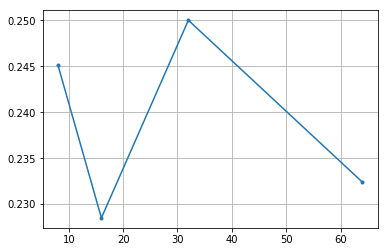

In [24]:
loss = [i[-1][0] for i in resultado_neuronas]
precission = [i[-1][1] for i in resultado_neuronas]

plt.plot(neurons, loss , '.-')
plt.grid()

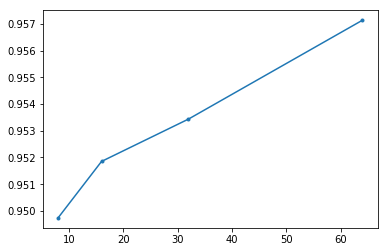

In [25]:
plt.plot(neurons, precission , '.-')

In [26]:
# lA PRECISIÓN MÁS ALTA ES EN 16 Y LA PÉRDIDA MÁS BAJA ES EN 8

## Modelo final con hyper parametros ajustados
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = Sequential()

classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 60982))
classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

classifier.fit(X_train, y_train, batch_size = 5, epochs = 100,callbacks=[es, rlr])

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

Epoch 1/100
4409/4409 [==============================] - 72s 16ms/step - loss: 0.5205 - acc: 0.6981 1s - loss: 0.5
Epoch 2/100
4409/4409 [==============================] - 91s 21ms/step - loss: 0.2686 - acc: 0.9256
Epoch 3/100
 875/4409 [====>.........................] - ETA: 1:16 - loss: 0.1550 - acc: 0.9714

ResourceExhaustedError: OOM when allocating tensor with shape[60982,16] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[Node: training_54/Adam/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Adam_54/beta_1/read, training_54/Adam/Variable/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [27]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1297,   23],
       [  80,  490]], dtype=int64)

In [ ]:
classifier.evaluate(X_test, y_test)

  64/1890 [>.............................] - ETA: 3:49

###### Regresión Logística

    array([[1297,   23],
           [  80,  490]]
          
###### Red Neuronal
    array([[1284,   36],
       [  63,  507]], dtype=int64)